# Particle ecology

This figure was made to give a first visual overview of the intra-collective particle ecology. We show the diversity of collective trajectories at the begining and end of the evolutionary trajectory. Then in a second panel, we zoom out on a single panel to show the trajectories of each type of particles. It is a good time to show how the ODE approximate the stochastic model. 

In [1]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.integrate

import estaudel.escaffolding as escaffolding
import estaudel.stochastic as stochastic
import estaudel.heredity.process as ehp
import estaudel.heredity.deterministic as ehd
import estaudel.heredity.stochastic as ehs

# Data
Here we extract the data from the full simulation in order to get the right traits values.

In [2]:
path = '../../projects/171214_heredity_dynamics/20180224_103155.pkle'
generations_to_extract = [1,9000]
tstep = 500

In [3]:
def load(path):
    out = escaffolding.Output(0,0,0,0)
    err = out.load(path)
    if not err:
        ehp.extract(out)
        out.save(path)
    return out
out = load(path)

# Doing small simulations

In general I do not record the full trajectories of all the collectives (it would take too much space) so this figure is made by doing a new simulation, using the resident traits and initial conditions that where extracted from the full simulation.

We turn off the mutations in this simulation to not overload the figure.

In [4]:
traj = {}
traj_sto = {}
time = np.linspace(0,out.parameters['T'],tstep)

for n in generations_to_extract:
    traj[n] = []
    traj_sto[n] = []

    for x,P in [(out.data['cp_value'][n-1,out.parents[n-1][i]], 
                 np.array(out.data['resident_pheno'][out.data['resident_id'][n,i]]))
                for i in range(out.parameters['D'])]:           
        # Initial conditions
        state = np.array(np.array([out.parameters['B']*x,out.parameters['B']*(1-x)]))
        
        # Deterministic trajectory 
        r,a = ehd.convert_phenotypes_to_lv(P, out.parameters['carrying_capacity'])
        func = partial(ehd.lotka_volterra,r=r,a=a)
        traj[n].append(scipy.integrate.odeint(func,
                                y0=state,
                                t=time))
        
        # Stochastic trajectory
        rates = partial(ehs.bd_rates,K=out.parameters['carrying_capacity'])
        growth_no_mutation = partial(
            stochastic.discrete_bdm_process,
            T=out.parameters['T'],
            steps=tstep,
            skip=1,
            mutation_rate=0,
            mutation_function=lambda x:None,
            rate_function=rates)
        traj_sto[n].append(growth_no_mutation(state=state, phenotypes=P)['trajectory'].transpose())

# Plot 

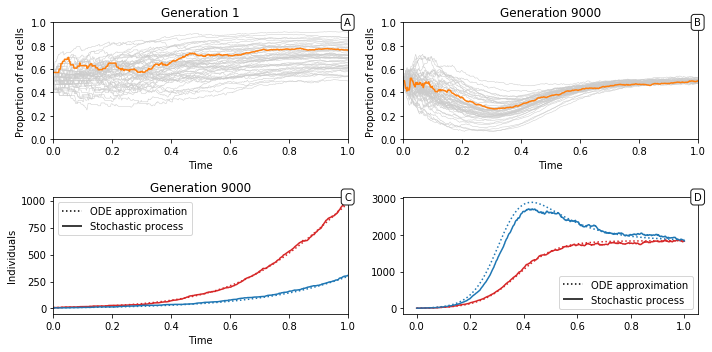

In [5]:
fig, ax = plt.subplots(2,2,figsize=(10,5))
for i, gen in enumerate(generations_to_extract):
    
    ### First panel: all collectives ###
    for ode, sto in zip(traj[gen],traj_sto[gen]):
        ax[0,i].plot(time, sto[:,0]/sto.sum(1), color=(.8,.8,.8),lw=.5)
    ax[0,i].plot(time, sto[:,0]/sto.sum(1), color='C1')
    
    ax[0,i].set(xlabel='Time', xlim=(0,1), ylim=(0,1),
            title='Generation {}'.format(gen), 
            ylabel='Proportion of {} cells'.format(ehs.COLOR_NAMES[0]))
    
    ### Second Panel: zooming on a single collective ###
    # Stochastic trajectory with a full line
    ax[1,i].plot(time, sto[:,0], color='C3')
    ax[1,i].plot(time, sto[:,1], color='C0')
    
    # ODEs with a dotted line
    ax[1,i].plot(time, ode[:,0], color='C3',ls=':')
    ax[1,i].plot(time, ode[:,1], color='C0',ls=':')
    
    # Legends and axis labels
    ax[1,i].vlines(0,0,0, linestyles=':', label='ODE approximation')
    ax[1,i].vlines(0,0,0, linestyles='-', label='Stochastic process')
    ax[1,i].legend()
    ax[1,0].set(xlabel='Time', xlim=(0,1),
            title='Generation {}'.format(gen), 
            ylabel='Individuals')


# Panel labels
bbox_legend = dict(xy=(1, 1), xycoords="axes fraction",
               ha='center', va='center',
                bbox=dict(boxstyle="round",
                   ec=(.1, 0.1, .1),
                   fc=(1., 1, 1),
               ))
ax[0,0].annotate('A',**bbox_legend)
ax[0,1].annotate('B',**bbox_legend)
ax[1,0].annotate('C',**bbox_legend)
ax[1,1].annotate('D',**bbox_legend)


plt.tight_layout()

fig.savefig('particle_ecology.pdf', bbox_to_inches='tight')